In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
 %cd /content/gdrive/My Drive/Cornell/2020-2021/Biomedical ML Final Project - Melted Paper

/content/gdrive/.shortcut-targets-by-id/13OShW0589KdYJRWaN9GrhtF2vtwdrUUW/Biomedical ML Final Project - Melted Paper


In [3]:
import os, time, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import skimage as sk
import skimage.transform
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Flatten, Input
from tensorflow.python.keras import Sequential

In [4]:
df = pd.read_table('Datasets/archive/all-mias/Info.txt', delimiter=' ')
df.SEVERITY = df.SEVERITY.fillna('N')
lookUp = df[['REFNUM', 'SEVERITY']].set_index('REFNUM').T.to_dict()
df.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,Unnamed: 7
0,mdb001,G,CIRC,B,535.0,425.0,197.0,NaN
1,mdb002,G,CIRC,B,522.0,280.0,69.0,NaN
2,mdb003,D,NORM,N,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,N,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0,NaN


In [5]:
def get_roi(path, df, le):
  images, labels = [], []
  lookUp = {}
  for row in df.iterrows():
    # Read the image.
    image = cv2.imread(os.path.join(path, str(row[1][0]) + '.jpg'), cv2.IMREAD_GRAYSCALE)
    image = image.reshape((image.shape[0], image.shape[1], 1))
    label = str(row[1][3])

    # If abnormal, crop around the tumor
    x2, y2 = 0, 0
    edge = image.shape[0] # mias is default 1024x1024
    if label != 'N' and str(row[1][4]) != 'nan':
      x, y = int(row[1][4]), int(row[1][5])
      x1 = x - 112
      if x1 < 0:
        x1, x2 = 0, 224
      if x2 != 224:
        x2 = x + 112
        if x2 > edge:
          x1, x2 = edge - 224, edge

      y1 = edge - y - 112
      if y1 < 0:
        y1, y2 = 0, 224
      else:
        y2 = edge - y + 112
        if y2 > edge:
          y1, y2 = edge - 224, edge
  
    # Normal case: crop around centre of image.
    else:
      x1, x2 = int(edge / 2 - 112), int(edge / 2 + 112)
      y1, y2 = int(edge / 2 - 112), int(edge / 2 + 112)

    images.append(image[y1:y2, x1:x2, :])
    labels.append(label)
    lookUp[str(row[1][0])] = (image[y1:y2, x1:x2, :], label)

  labels = to_categorical(le.fit_transform(labels))
  return images, labels, lookUp

In [6]:
le = LabelEncoder()
images, labels, img_dict = get_roi('Datasets/archive/all-mias', df, le)

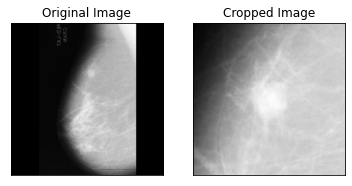

In [7]:
mdb023 = mpimg.imread('Datasets/archive/all-mias/mdb023.jpg')
img = img_dict['mdb023'][0]
# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(mdb023, cmap='gray');
ax[0].set_title('Original Image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].imshow(img.reshape((img.shape[0], img.shape[1])), cmap='gray');
ax[1].set_title('Cropped Image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.show()

In [8]:
# 60-20-20 train-val-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, stratify=labels, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, shuffle=True)
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [9]:
def calculate_class_weights(y_train, le):
    y_train = le.inverse_transform(np.argmax(y_train, axis=1))
    weights = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
    return dict(enumerate(weights))
    # return class_weights

In [10]:
class_weights = calculate_class_weights(y_train, le)
print(class_weights)

{0: 1.6097560975609757, 1: 2.0625, 2: 0.528}


In [11]:
def get_class_count(labels):
  num_classes = len(labels[0])
  counts = np.zeros(num_classes)
  for label in labels:
    for i in range(num_classes):
      counts[i] += label[i]
  return counts.tolist()

In [12]:
def random_shearing(img):
  tf = sk.transform.AffineTransform(shear=random.uniform(-0.3, 0.3))
  return sk.transform.warp(img, tf, order=1, preserve_range=True, mode='wrap')

def random_noise(img):
  return sk.util.random_noise(img)

def random_rotation(img):
  return sk.transform.rotate(img, random.uniform(-30, 30))

def horizontal_flip(img):
  return img[:, ::-1]

In [13]:
transformation_functions = {
  'shear': random_shearing,
  'rotate': random_rotation,
  'noise': random_noise,
  'horizontal_flip': horizontal_flip,
}

In [63]:
def transform_images(img, transforms: dict):
  num_transformations = random.randint(0, len(transforms))
  transformed_image = img
  for i in range(num_transformations):
    key = random.choice(list(transforms))
    transformed_image = transforms[key](img)

  return transformed_image

In [61]:
def generate_more_images(images, labels, transformation_functions):
  more_images = images
  more_labels = labels

  class_balance = get_class_count(labels)
  img_to_add = [max(class_balance) - i for i in class_balance]
  
  for i in range(len(img_to_add)):
    if int(img_to_add[i]) == 0:
      continue
    label = np.zeros(len(img_to_add))
    label[i] = 1
    class_label_indices = [i for i, x in enumerate(labels) if np.array_equal(x, label)]
    class_images = [images[i] for i in class_label_indices]

    for k in range(int(img_to_add[i])):
      transformed_image = transform_images(class_images[k % len(class_images)], transformation_functions)
      transformed_image = transformed_image.reshape(1, 224, 224, 1)
  
      more_images = np.append(more_images, transformed_image, axis=0)
      more_labels = np.append(more_labels, label.reshape(1, len(label)), axis=0)
  return more_images, more_labels

In [ ]:
y_train_before = y_train
X_train, y_train = generate_more_images(X_train, y_train, transformation_functions)

In [64]:
print('Training data size BEFORE augmenting: {}'.format(len(y_train_before)))
print('Training data size AFTER augmenting: {}'.format(len(y_train)))

Training data size BEFORE augmenting: 198
Training data size AFTER augmenting: 375


In [65]:
def create_vgg16_model():
  input = Input(shape=(224, 224, 1))
  img_conc = Concatenate()([input, input, input])

  # VGG19 model with pre-trained ImageNet weights.
  model = Sequential()

  # Base convolutional layers
  model.add(VGG16(include_top=False, weights="imagenet", input_tensor=img_conc))

  # FC layers
  model.add(Flatten())
  FC = Sequential(name='FullyConnected')
  FC.add(Dropout(0.2, seed=16, name='Dropout'))
  FC.add(Dense(units=512, activation='relu', name='Dense1'))
  FC.add(Dense(units=64, activation='relu', name='Dense2'))
  FC.add(Dense(3, activation='softmax', kernel_initializer="random_uniform", name='Output'))
  model.add(FC)
  print(model.summary())
  print(FC.summary())
  return model

In [69]:
model_16 = create_vgg16_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
FullyConnected (Sequential)  (None, 3)                 12878595  
Total params: 27,593,283
Trainable params: 27,593,283
Non-trainable params: 0
_________________________________________________________________
None
Model: "FullyConnected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 512)               12845568  
_____________

In [70]:
batch_size=20
max_epoch_frozen=20
max_epoch_unfrozen=20

def train_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size):
  # Only train fully connected layers by freezing CNN layers
  model.layers[0].trainable = False
  compile_model(model, 1e-5)
  history1 = fit_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size)
  training_results(history1, frozen=True)

  # # Unfreeze all layers
  # model.layers[0].trainable = True
  # compile_model(model, 1e-5)
  # history2 = fit_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size)
  # training_results(history2, frozen=False)

  return history1

def compile_model(model, learning_rate):
  model.compile(optimizer=Adam(learning_rate), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

def fit_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size):
  history = model.fit(
      x=X_train,
      y=y_train,
      class_weight=class_weights,
      batch_size=batch_size,
      steps_per_epoch=len(X_train) // batch_size,
      validation_data=(X_val, y_val),
      validation_steps=len(X_val) // batch_size,
      epochs=epoch,
  )
  return history

In [71]:
def training_results(history, frozen) -> None:
  fig = plt.figure()
  n = len(history.history["loss"])
  plt.figure()
  plt.plot(np.arange(0, n), history.history["loss"], label="train set")
  plt.plot(np.arange(0, n), history.history["val_loss"], label="validation set")
  plt.title('Training Loss ' + ('(Frozen)' if frozen else '(Unfrozen)'))
  plt.legend(loc='upper right')
  plt.xlabel('Epochs')
  plt.ylabel('Cross Entropy Loss')
  plt.savefig('output/training-loss-baseline.png')
  plt.show()

  fig = plt.figure()
  n = len(history.history["loss"])
  plt.figure()
  plt.plot(np.arange(0, n), history.history["categorical_accuracy"], label="train set")
  plt.plot(np.arange(0, n), history.history["val_categorical_accuracy"], label="validation set")
  plt.title('Training Accuracy ' + ('(Frozen)' if frozen else '(Unfrozen)'))
  plt.legend(loc='upper right')
  plt.xlabel('Epochs')
  plt.ylabel("Accuracy")
  plt.ylim(0, 1)
  plt.savefig('output/training-accuracy-baseline.png')
  plt.show()

In [72]:
def plot_roc(y_true, y_pred, le):
  fpr, tpr, roc_auc = {}, {}, {}

  for i in range(le.classes_.size):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(le.classes_))]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(le.classes_.size):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  mean_tpr /= le.classes_.size

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  fpr['micro'], tpr['micro'], _ = roc_curve(y_true.ravel(), y_pred.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
  plt.figure(figsize=(8, 5))

  plt.plot([0, 1], [0, 1], 'k--', color='black', lw=2)
  plt.annotate('Random Guess', (.54, .49), color='black')

  plt.plot(fpr['micro'], tpr['micro'],
            label='Micro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='red', linestyle=':', lw=3)

  plt.plot(fpr['macro'], tpr['macro'],
            label='Macro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc['macro']),
            color='black', linestyle=':', lw=3)

  colors = ['#3972ba', '#ab923e', '#3bb300']
  for i, color in zip(range(len(le.classes_)), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC of Class {0} (area = {1:0.2f})'
                      ''.format(le.classes_[i], roc_auc[i]))

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.savefig('output/baseline-ROC.png')
  plt.show()

  plt.figure(figsize=(8, 5))
  plt.plot(fpr['micro'], tpr['micro'],
            label='Micro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='red', linestyle=':', lw=3)

  plt.plot(fpr['macro'], tpr['macro'],
            label='Macro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc['macro']),
            color='black', linestyle=':', lw=3)

  colors = ['#3972ba', '#ab923e', '#3bb300']
  for i, color in zip(range(len(le.classes_)), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC of Class {0} (area = {1:0.2f})'
                      ''.format(le.classes_[i], roc_auc[i]))

  plt.xlim(0, 0.2)
  plt.ylim(0.8, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve (Top Left)')
  plt.legend(loc='lower right')
  plt.savefig('output/baseline-ROC-top-left.png')
  plt.show()

Epoch 1/20
18/18 [==============================] - 2s 115ms/step - loss: 1.3884 - categorical_accuracy: 0.3778 - val_loss: 1.4436 - val_categorical_accuracy: 0.1500
Epoch 2/20
18/18 [==============================] - 2s 104ms/step - loss: 1.2144 - categorical_accuracy: 0.4394 - val_loss: 1.3405 - val_categorical_accuracy: 0.1667
Epoch 3/20
18/18 [==============================] - 2s 102ms/step - loss: 1.0915 - categorical_accuracy: 0.4958 - val_loss: 1.3018 - val_categorical_accuracy: 0.1667
Epoch 4/20
18/18 [==============================] - 2s 102ms/step - loss: 0.9666 - categorical_accuracy: 0.5690 - val_loss: 1.2827 - val_categorical_accuracy: 0.2333
Epoch 5/20
18/18 [==============================] - 2s 103ms/step - loss: 0.8816 - categorical_accuracy: 0.6310 - val_loss: 1.2731 - val_categorical_accuracy: 0.2333
Epoch 6/20
18/18 [==============================] - 2s 104ms/step - loss: 0.7766 - categorical_accuracy: 0.7183 - val_loss: 1.2102 - val_categorical_accuracy: 0.2833
Epoc

<Figure size 432x288 with 0 Axes>

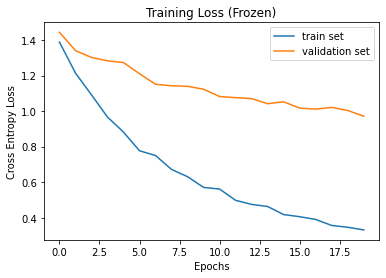

<Figure size 432x288 with 0 Axes>

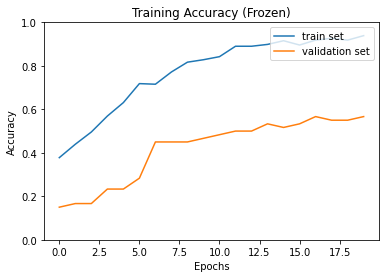

In [73]:
batch_size = 20
max_epoch = 20
history_frozen = train_model(model_16, X_train, X_val, y_train, y_val, class_weights, max_epoch, batch_size)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
def evaluate_model(prediction, y_true, le):
  true_y = le.inverse_transform(np.argmax(y_true, axis=1))
  pred_y = le.inverse_transform(np.argmax(prediction, axis=1))

  # Calculate accuracy
  accuracy = float('{:.4f}'.format(accuracy_score(true_y, pred_y)))
  print("Accuracy = {}\n".format(accuracy))

  cm = confusion_matrix(true_y, pred_y) 
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_norm[np.isnan(cm_norm)] = 0
  plot_confusion_matrix(cm_norm, le)

In [ ]:
def plot_confusion_matrix(cm, le):
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap=plt.cm.Blues, vmin=0, vmax=1)  # annot=True to annotate cells

  # Set labels, title, ticks and axis range.
  ax.set_xlabel('Predicted Classes')
  ax.set_ylabel('True Classes')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(le.classes_)
  ax.yaxis.set_ticklabels(le.classes_)
  plt.tight_layout()
  bottom, top = ax.get_ylim()
  plt.show()
  plt.savefig('output/confusion_mat.png')

Accuracy = 0.6061



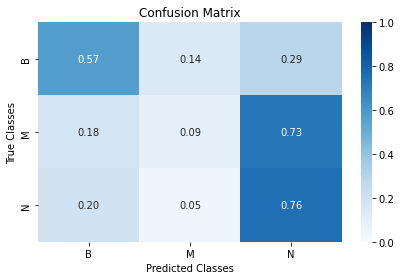

<Figure size 432x288 with 0 Axes>

In [ ]:
# validation
prediction = model_16.predict(X_val, batch_size=20)
evaluate_model(prediction, y_val, le)

### Testing

Accuracy = 0.4697



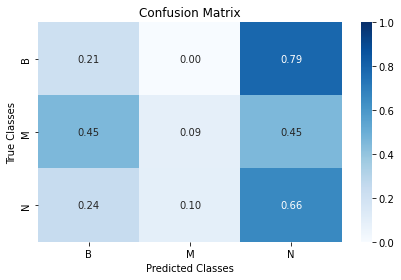

<Figure size 432x288 with 0 Axes>

In [ ]:
predictions = model_16.predict(x=X_test)
evaluate_model(prediction, y_test, le)